Code block below set parameters.

In [1]:
import numpy as np
import time

mode_number = 2**8
iter_number = 10**7
plot_interval = 5000
record_interval = iter_number // 10000
power_interval = max(iter_number // 1000000, 1)
# zeta is changing every single iteration
zeta_ini = -10 - 0.0001
zeta_end = +15 + 0.0001
zeta_step = (zeta_end - zeta_ini) / (iter_number - 1)

f_A = 3
f_B = 0
d_2 = 0.04
delta_t = 1e-4 # commonly used time step
# delta_t = 1e-5
J_back_r = 0.1

noise_level = 1e-3

seed_number = -1
# seed_number = 8


D_int = np.zeros(mode_number, dtype=np.complex128)
for i in range(mode_number):
    D_int[i] = (i - mode_number / 2) ** 2 * d_2

D_int = np.fft.ifftshift(D_int)

time_str = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

random_seed = np.random.randint(0, 2**32)
# random_seed = 156089458
rng = np.random.default_rng(random_seed)


plot_flag = False
plot_flag = True
cProfile_test = False
# cProfile_test = True
noise_flag = False
noise_flag = True


print(time_str)


2024-09-03_17-33-26


Code below do the simulations.

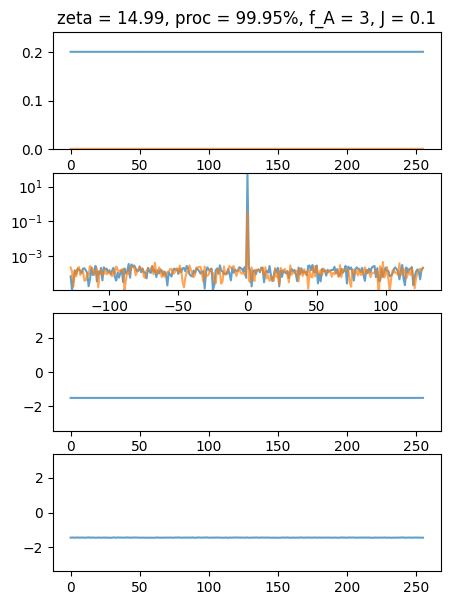

End main loop
Time used: 489.37 s


In [2]:
from numba import jit, objmode
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from IPython import display
import glob
import time


@jit(nopython=True)
def noise(mode_number, rng, noise_level = noise_level):
    white_noise = rng.standard_normal(mode_number) + 1j * rng.standard_normal(mode_number)
    return white_noise * noise_level


@jit(nopython=True)
def cal_power(x):
    mode_number = len(x)
    return np.sum(np.abs(x)**2) / mode_number


@jit(nopython=True)
def split_step(A_0, zeta, f, D_int, delta_t, B, B_avg_pow, J_back_r=0, noise_flag=False, rng = rng):
    A_1 = np.exp(1j * (np.abs(A_0)**2 + 2 * B_avg_pow) * delta_t) * A_0
    A_1_freq = np.fft.fft(A_1)
    A_2_freq = np.exp(-(1 + 1j * zeta + 1j * D_int) * delta_t) * A_1_freq
    A_2 = np.fft.ifft(A_2_freq)
    A_3 = A_2 + f * delta_t
    A_4 = A_3 + 1j * J_back_r * delta_t * B # backscattering term from backwards mode
    if noise_flag:
        A_4 += noise(mode_number, rng) * delta_t
    return A_4


################
# Main loop
@jit(nopython=True)
def main_loop(iter_number, plot_interval, record_interval, zeta_ini, zeta_step, zetas, A, B, f_A, f_B, D_int, delta_t, J_back_r, noise_flag, rng, record_power_A, record_power_B, record_waveform_A, record_waveform_B, power_interval):
    zeta = zeta_ini - zeta_step
    for i in range(iter_number):
        zeta = zeta + zeta_step
        power_A = cal_power(A)
        power_B = cal_power(B)
        A_new = split_step(A, zeta, f_A, D_int, delta_t, B, power_B, J_back_r, noise_flag, rng)
        B_new = split_step(B, zeta, f_B, D_int, delta_t, A, power_A, J_back_r, noise_flag, rng)
        A, B = A_new, B_new

        if i % power_interval == 0:
            zeta_index = i // power_interval
            zetas[zeta_index] = zeta
            record_power_A[zeta_index] = power_A
            record_power_B[zeta_index] = power_B

        if i % record_interval == 0:
            record_waveform_A[i // record_interval] = A
            record_waveform_B[i // record_interval] = B

        if plot_flag == True and i % plot_interval == 0:
            with objmode():
                figure_plot(A, B, i, zeta, ax, ax_freq, line_A, line_B, line_A_freq, line_B_freq)
################


def figure_plot(A, B, i, zeta, ax, ax_freq, line_A, line_B, line_A_freq, line_B_freq):
    line_A.set_ydata(np.abs(A))
    line_B.set_ydata(np.abs(B))
    y_max = np.max([np.max(np.abs(A)), np.max(line_A.get_ydata())])
    ax.set_ylim(0, 1.2 * y_max)
    ax.title.set_text(f"zeta = {zeta:.2f}, proc = {i / iter_number * 100:.2f}%, f_A = {f_A}, J = {J_back_r}")

    A_freq = np.fft.fftshift(np.fft.fft(A))
    B_freq = np.fft.fftshift(np.fft.fft(B))
    line_A_freq.set_ydata(np.abs(A_freq))
    line_B_freq.set_ydata(np.abs(B_freq))
    y_freq_max = np.max(np.abs(A_freq))
    ax_freq.set_ylim(np.min(np.abs(A_freq)), 1.2 * y_freq_max)
    ax_freq.set_yscale('log')

    line_A_phase.set_ydata(np.angle(A))
    line_B_phase.set_ydata(np.angle(B))

    fig.canvas.draw()
    fig.canvas.flush_events()
    display.clear_output(wait=True)
    display.display(fig)



# Initialization
if seed_number != -1:
    # load seed
    file_seed_A = glob.glob(f"../seeds/seed_{seed_number}_A_*.npy")[0]
    file_seed_B = glob.glob(f"../seeds/seed_{seed_number}_B_*.npy")[0]
    A = np.load(file_seed_A)
    B = np.load(file_seed_B)
    print(f"Seed loaded: {file_seed_A}, {file_seed_B}")
else:
    A = noise(mode_number, rng)
    B = noise(mode_number, rng)
    print("Start from random noise")
A_freq = np.fft.fftshift(np.fft.fft(A))
B_freq = np.fft.fftshift(np.fft.fft(B))

zetas = np.zeros(iter_number // power_interval)
record_power_A = np.zeros(iter_number // power_interval)
record_power_B = np.zeros(iter_number // power_interval)
record_waveform_A = np.zeros((iter_number // record_interval, mode_number), dtype=np.complex128)
record_waveform_B = np.zeros((iter_number // record_interval, mode_number), dtype=np.complex128)

if plot_flag:
    # plt.ion()
    fig, axs = plt.subplots(4)
    fig.set_size_inches(5, 7)
    # fig.canvas.manager.window.resizable(True, True)
    ax, ax_freq, ax_phase_A, ax_phase_B = axs[0], axs[1], axs[2], axs[3]
    line_A, = ax.plot(np.abs(A), alpha = 0.7)
    line_B, = ax.plot(np.abs(B), alpha = 0.7)
    xs_freq = np.arange(-mode_number / 2, mode_number / 2)
    line_A_freq, = ax_freq.plot(xs_freq, np.abs(A_freq), alpha = 0.7)
    line_B_freq, = ax_freq.plot(xs_freq, np.abs(B_freq), alpha = 0.7)
    line_A_phase, = ax_phase_A.plot(np.angle(A), alpha = 0.7)
    line_B_phase, = ax_phase_B.plot(np.angle(B), alpha = 0.7)
    display.clear_output(wait=True)
    display.display(fig)
    plt.close()

start_time = time.time()

print("Start main loop")
main_loop(iter_number, plot_interval, record_interval, zeta_ini, zeta_step, zetas, A, B, f_A, f_B, D_int, delta_t, J_back_r, noise_flag, rng, record_power_A, record_power_B, record_waveform_A, record_waveform_B, power_interval)
print("End main loop")

end_time = time.time()

print(f"Time used: {end_time - start_time:.2f} s")

# plt.ioff()
# plt.show()

Code below plot the figures.

length of zetas: 1000000
length of record_waveform: 10000


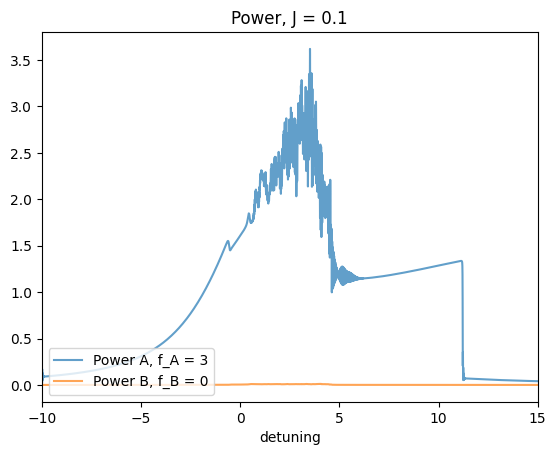

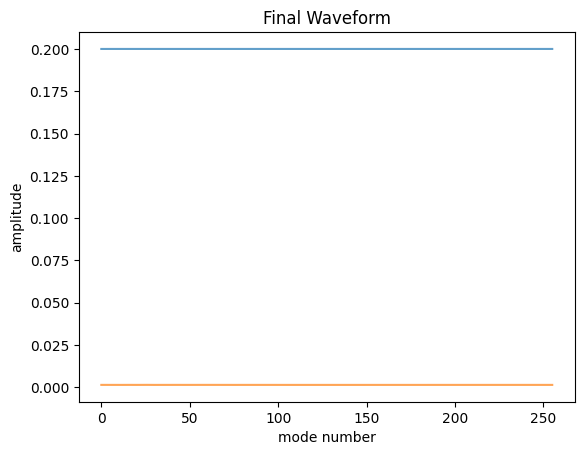

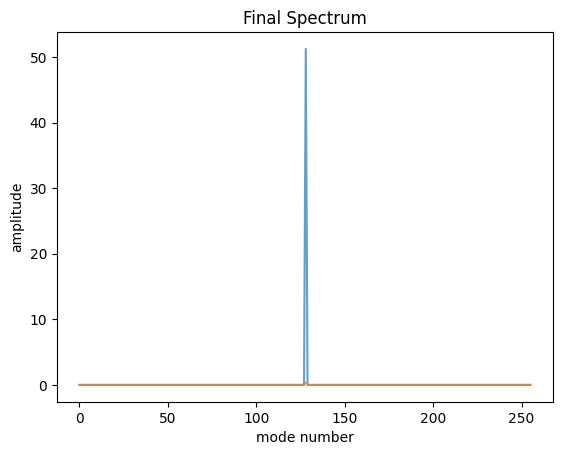

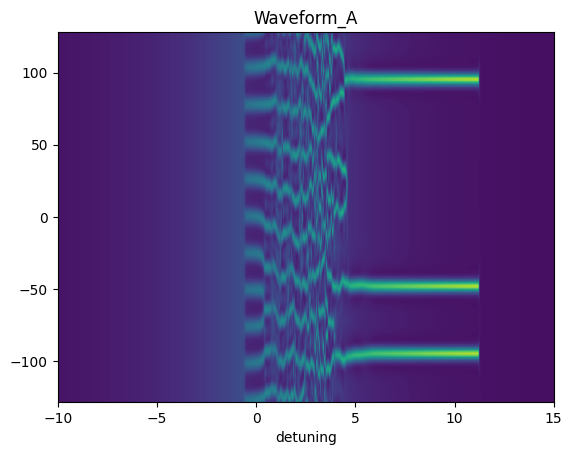

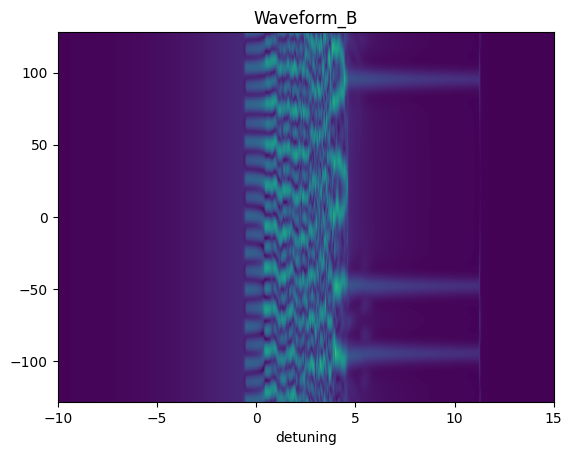

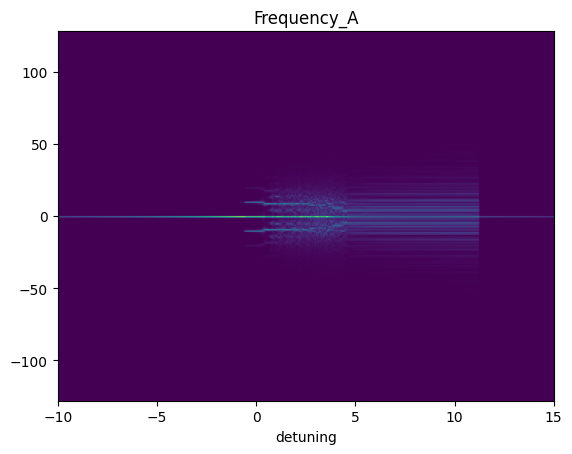

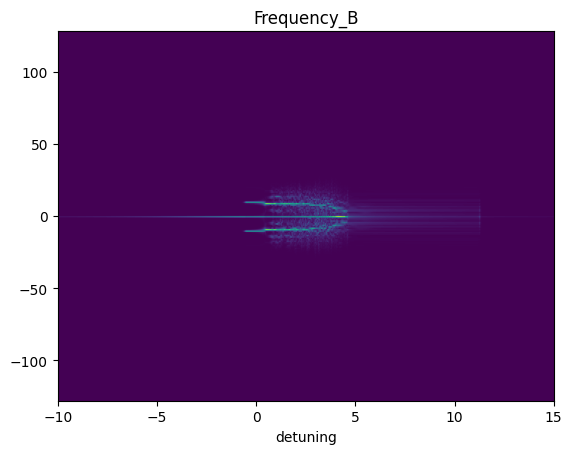

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt


def result_plot(record_power_A, record_power_B, record_waveform_A, record_waveform_B, zetas, time_str, f_A, f_B, J_back_r, mode_number, zeta_ini, zeta_end):
    # Plot power
    plt.figure()
    plt.plot(zetas, record_power_A, label=f'Power A, f_A = {f_A}', alpha = 0.7)
    plt.plot(zetas, record_power_B, label=f'Power B, f_B = {f_B}', alpha = 0.7)
    plt.xlim(zeta_ini, zeta_end)
    plt.title(f"Power, J = {J_back_r}")
    plt.xlabel("detuning")
    plt.legend(loc = "lower left")

    # Plot waveform heatmap
    record_freq_A = np.fft.fftshift(np.fft.fft(record_waveform_A, axis=1), axes=1)
    record_freq_B = np.fft.fftshift(np.fft.fft(record_waveform_B, axis=1), axes=1)

    # plot final waveform, with mode number as horizontal axis
    plt.figure()
    plt.plot(np.abs(record_waveform_A[-1]), label = "A", alpha = 0.7)
    plt.plot(np.abs(record_waveform_B[-1]), label = "B", alpha = 0.7)
    plt.title("Final Waveform")
    plt.xlabel("mode number")
    plt.ylabel("amplitude")

    # plot final spectrum, with mode number as horizontal axis
    plt.figure()
    plt.plot(np.abs(record_freq_A[-1]), label = "A", alpha = 0.7)
    plt.plot(np.abs(record_freq_B[-1]), label = "B", alpha = 0.7)
    plt.title("Final Spectrum")
    plt.xlabel("mode number")
    plt.ylabel("amplitude")

    record_freq_A = record_freq_A.T
    record_freq_B = record_freq_B.T
    record_waveform_A = record_waveform_A.T
    record_waveform_B = record_waveform_B.T

    plt.figure()
    plt.imshow(np.abs(record_waveform_A), aspect='auto', extent=[zeta_ini, zeta_end, -mode_number / 2, mode_number / 2])
    # plt.colorbar()
    plt.title("Waveform_A")
    plt.xlabel("detuning")

    plt.figure()
    plt.imshow(np.abs(record_waveform_B), aspect='auto', extent=[zeta_ini, zeta_end, -mode_number / 2, mode_number / 2])
    # plt.colorbar()
    plt.title("Waveform_B")
    plt.xlabel("detuning")

    # plot the frequency in a heatmap
    plt.figure()
    plt.imshow(np.abs(record_freq_A), aspect='auto', extent=[zeta_ini, zeta_end, -mode_number / 2, mode_number / 2])
    # plt.colorbar()
    plt.title("Frequency_A")
    plt.xlabel("detuning")

    plt.figure()
    plt.imshow(np.abs(record_freq_B), aspect='auto', extent=[zeta_ini, zeta_end, -mode_number / 2, mode_number / 2])
    # plt.colorbar()
    plt.title("Frequency_B")
    plt.xlabel("detuning")

    # plt.show()


time_str = sys.argv[1]

print("length of zetas:", len(zetas))
print("length of record_waveform:", len(record_waveform_A))


result_plot(record_power_A, record_power_B, record_waveform_A, record_waveform_B, zetas, time_str, f_A, f_B, J_back_r, mode_number, zeta_ini, zeta_end)
